In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


In [31]:

G_val = 3.5
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 1000
DECAY = np.exp(a+np.log(LR)*b)
params['lr_receptors'] = np.zeros(N)
params['lr_scaling'] = 1
params['taoj'] =  DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


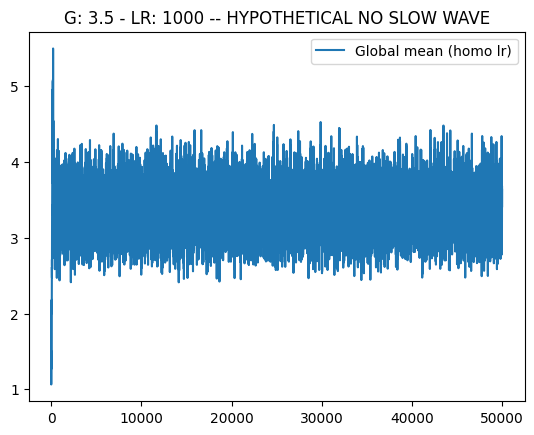

In [32]:

plt.plot(np.mean(rates_dyn,axis=0), label="Global mean (homo lr)", linestyle="-")
plt.title(f"G: {params['G']} - LR: {params['lrj']} -- HYPOTHETICAL NO SLOW WAVE")
plt.legend()
plt.show()

In [ ]:
HET_REGION = 0
HOM_REGION = 1

In [45]:

params_heter = params.copy()
params_heter['lr_receptors'] = np.zeros(N)
params_heter['lr_receptors'][HET_REGION] = 1
params_heter['lr_scaling'] = 1
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


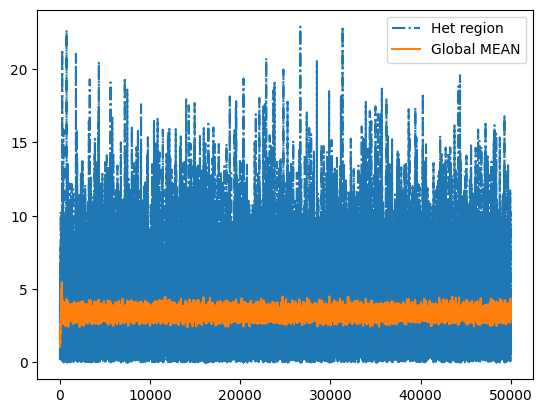

In [46]:
plt.plot(rates_heter[HET_REGION,:50000], label="Het region", linestyle="-.")
plt.plot(np.mean(rates_heter[np.arange(N) != HET_REGION, :50000], axis=0), label="Global MEAN", linestyle="-")
#plt.ylim([0,12])
plt.legend()
plt.show()

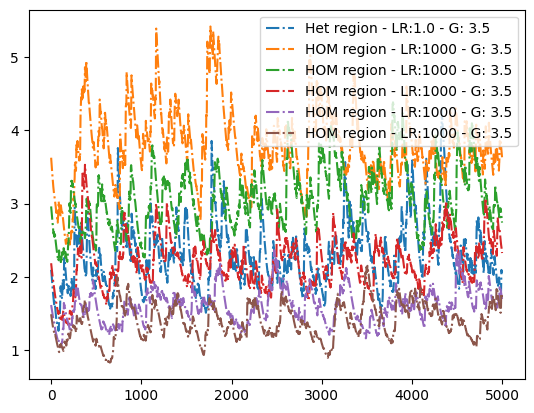

In [47]:
plt.plot(fic_t_heter[HET_REGION,:5000], label=f"Het region - LR:{params_heter['lr_receptors'][HET_REGION]} - G: {params_heter['G']}", linestyle="-.")
#plt.plot(np.mean(fic_t_heter[np.arange(N) != HET_REGION, :5000], axis=0), label="Global MEAN", linestyle="-")plt.plot(fic_t_heter[HOM_REGION,:])
plt.plot(fic_t_heter[HOM_REGION:HOM_REGION+5,:5000].T, label=f"HOM region - LR:{params['lrj']} - G: {params['G']}" , linestyle="-.")
plt.legend()
plt.show()

## Going from slow waves to a wake region

In [37]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_receptors'] = np.zeros(N)
params['lr_scaling'] = 1
params['taoj'] =  DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [38]:
HET_REGION = 0

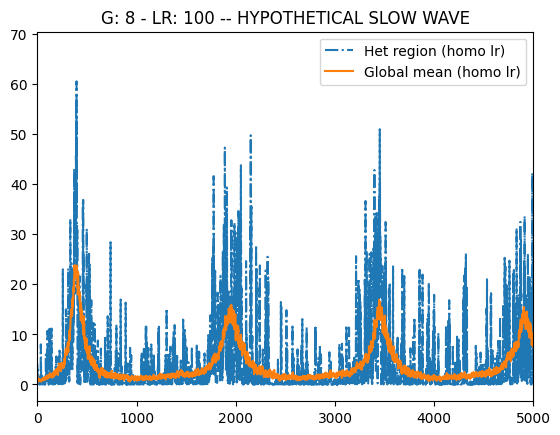

In [39]:

plt.plot(rates_dyn[HET_REGION,:], label="Het region (homo lr)", linestyle="-.")
plt.plot(np.mean(rates_dyn,axis=0), label="Global mean (homo lr)", linestyle="-")
plt.xlim([0,5000])
plt.title(f"G: {params['G']} - LR: {params['lrj']} -- HYPOTHETICAL SLOW WAVE")
plt.legend()
plt.show()

In [40]:

params_heter = params.copy()
params_heter['lr_receptors'] = np.zeros(N)
params_heter['lr_receptors'][HET_REGION] = 1000
params_heter['lr_scaling'] = 1
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


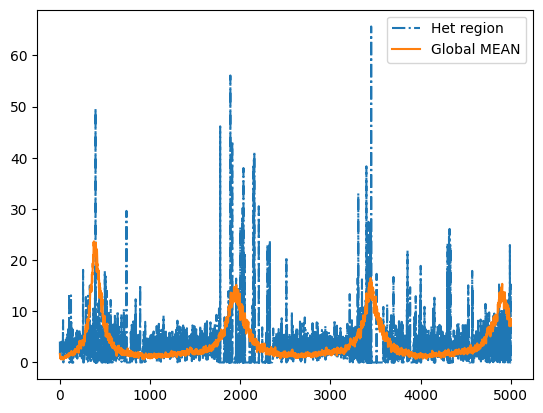

In [41]:
plt.plot(rates_heter[HET_REGION,:5000], label="Het region", linestyle="-.")
plt.plot(np.mean(rates_heter[np.arange(N) != HET_REGION, :5000], axis=0), label="Global MEAN", linestyle="-")
#plt.ylim([0,12])
plt.legend()
plt.show()

In [8]:
def get_autcorr(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = rates - np.mean(rates)    
    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    return autocorr



Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 1651 samples (1.651 s)

Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 1651 samples (1.651 s)

Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method

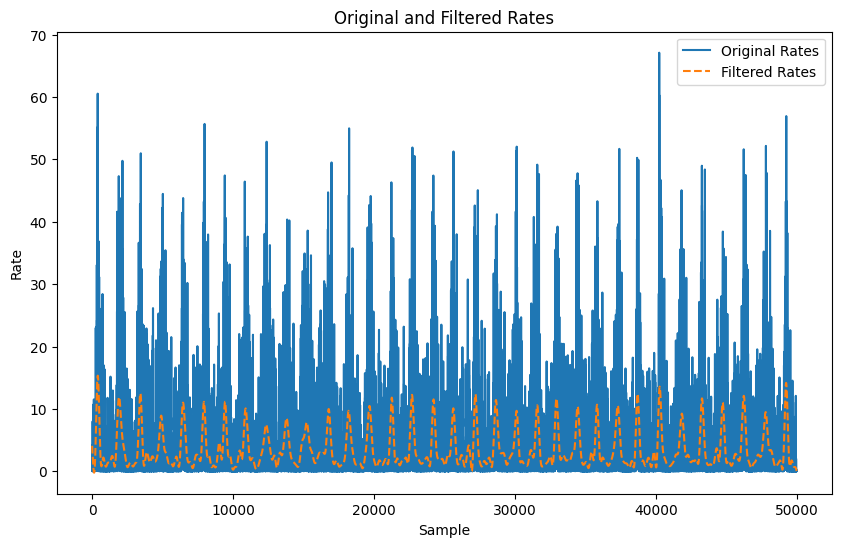

In [42]:
from mne.filter import filter_data

# Apply the filter to the data
filtered_rates_dyn_heter_region = filter_data(rates_dyn[HET_REGION,:], 1000, None, 2)
filtered_rates_dyn = filter_data(rates_dyn[HET_REGION,:], 1000, None, 2)
filtered_rates_heter = filter_data(rates_heter[HET_REGION,:], 1000, None, 2)
filtered_rates_dyn_average = filter_data(np.mean(rates_dyn,axis=0), 1000, None, 2)
# Plot the original and filtered data
plt.figure(figsize=(10, 6))
plt.plot(rates_dyn[HET_REGION,:], label='Original Rates')
plt.plot(filtered_rates_dyn, label='Filtered Rates', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Rate')
plt.legend()
#plt.xlim([0,5000])
plt.title('Original and Filtered Rates')
plt.show()

In [10]:

autocorr_hete = get_autcorr(filtered_rates_dyn)
autocorr_homo = get_autcorr(filtered_rates_heter)
autocorr_homo_heter_region = get_autcorr(filtered_rates_dyn_heter_region)
autocorr_homo_avg = get_autcorr(filtered_rates_dyn_average)

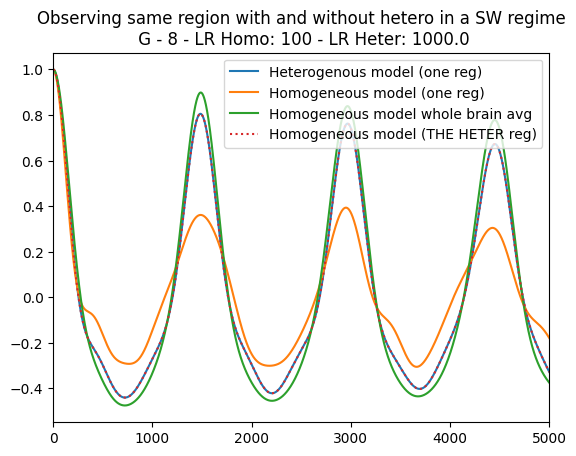

In [11]:
lags = np.arange(0,len(autocorr_hete))
plt.plot(lags, autocorr_hete,label='Heterogenous model (one reg)')
plt.plot(lags,autocorr_homo,label='Homogeneous model (one reg)')
plt.plot(lags,autocorr_homo_avg, label='Homogeneous model whole brain avg')
plt.plot(lags,autocorr_homo_heter_region,label='Homogeneous model (THE HETER reg)',linestyle=':')
plt.xlim([0,5000])
plt.title(f"Observing same region with and without hetero in a SW regime\n G - {params['G']} - LR Homo: {params['lrj']} - LR Heter: {params_heter['lr_receptors'][HET_REGION]}")
plt.legend()

In [43]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_homo_restreg = get_autcorr(np.mean(rates_heter[1:],axis=0))


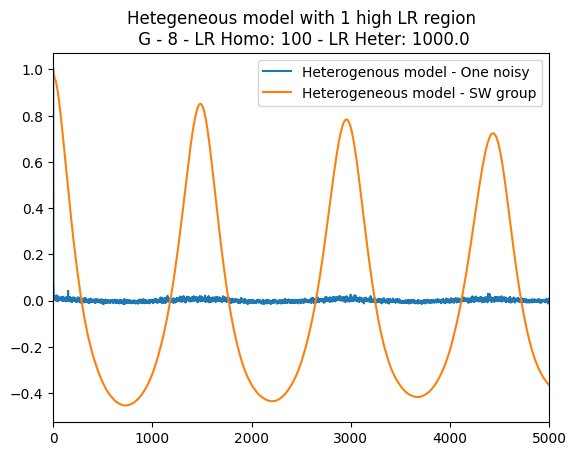

In [45]:
lags = np.arange(0,len(autocorr_homo_restreg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - One noisy')
plt.plot(lags,autocorr_homo_restreg,label='Heterogeneous model - SW group')

plt.xlim([0,5000])
plt.title(f"Hetegeneous model with 1 high LR region\n G - {params['G']} - LR Homo: {params['lrj']} - LR Heter: {params_heter['lr_receptors'][HET_REGION]}")
plt.legend()

## Comparing a region in two different models

In [46]:

G_val = 8
C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]
params = dmf.default_params(C=C)
fit_res = np.load("./data/fit_res_3-44.npy")
b = fit_res[0] # First element is the slope
a = fit_res[1]
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 100
DECAY = np.exp(a+np.log(LR)*b)
params['lr_receptors'] = np.zeros(N)
params['lr_scaling'] = 1
params['taoj'] =  DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
params["return_rate"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)


In [48]:
HET_REGION = 0
params_heter = params.copy()
params_heter['lr_receptors'] = np.zeros(N)
params_heter['lr_receptors'][HET_REGION] = 1000
params_heter['lr_scaling'] = 1
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


In [50]:

autocorr_hete_onereg = get_autcorr(rates_heter[HET_REGION,:])
autocorr_homo_onereg = get_autcorr(rates_dyn[HET_REGION,:])


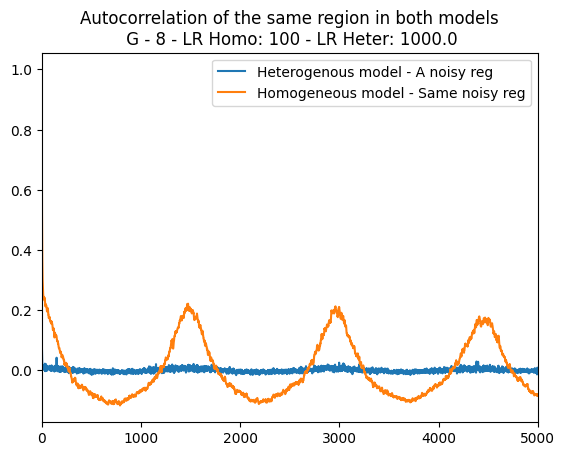

In [51]:
lags = np.arange(0,len(autocorr_homo_onereg))
plt.plot(lags, autocorr_hete_onereg,label='Heterogenous model - A noisy reg')
plt.plot(lags,autocorr_homo_onereg,label='Homogeneous model - Same noisy reg')

plt.xlim([0,5000])
plt.title(f"Autocorrelation of the same region in both models\n G - {params['G']} - LR Homo: {params['lrj']} - LR Heter: {params_heter['lr_receptors'][HET_REGION]}")
plt.legend()

## Groups of heterogeneous region in a SW regime

In [12]:
import numpy as np

def top_m_connectivity_regions(connectivity_matrix, region_index, M):
    """
    Returns the indices of the M regions with the highest connectivity strength
    with the given region_index.

    Parameters:
        connectivity_matrix (np.ndarray): 2D array of connectivity strengths.
        region_index (int): The index of the reference region.
        M (int): Number of top connected regions to return.

    Returns:
        List[int]: Sorted list of region indices (highest connectivity first).
    """
    # Copy the row corresponding to the region to avoid modifying the original matrix
    connectivity = np.array(connectivity_matrix[region_index], copy=True)
    
    # Exclude self connectivity by setting it to -inf
    connectivity[region_index] = -np.inf
    
    # Get the indices of the top M connectivity values
    top_indices = np.argpartition(connectivity, -M)[-M:]
    
    # Sort these indices by descending order of connectivity
    top_indices_sorted = top_indices[np.argsort(-connectivity[top_indices])]
    
    return top_indices_sorted.tolist()
    
# Example usage:
if __name__ == "__main__":
    # Example connectivity matrix (symmetric for this example)
    connectivity_matrix = np.array([
        [1.0, 0.2, 0.5, 0.3],
        [0.2, 1.0, 0.6, 0.1],
        [0.5, 0.6, 1.0, 0.8],
        [0.3, 0.1, 0.8, 1.0]
    ])
    
    region_index = 2  # For example, region 2
    M = 2
    top_regions = top_m_connectivity_regions(connectivity_matrix, region_index, M)
    print("Top {} regions connected to region {}: {}".format(M, region_index, top_regions))

Top 2 regions connected to region 2: [3, 1]


In [13]:
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
less_connected = np.argsort(node_strength)[:10]


In [14]:

params_heter = params.copy()
params_heter['lr_receptors'] = np.zeros(N)
HETEROGENITY_VECTOR = np.zeros(N)
HETEROGENITY_VECTOR[less_connected] = 1000
params_heter['lr_receptors'] = HETEROGENITY_VECTOR
params_heter['lr_scaling'] = 1
rates_heter, rates_inh_heter, bold_heter, fic_t_heter = dmf.run(params_heter, 50000)


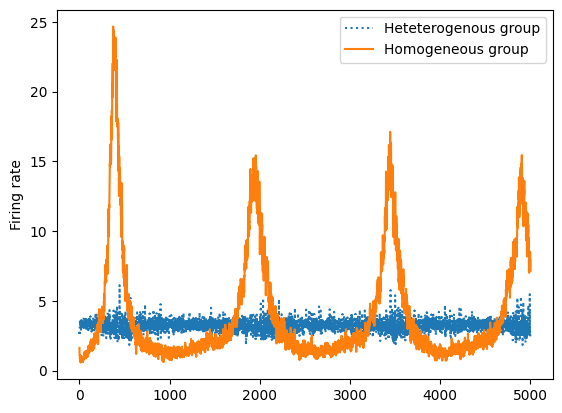

In [15]:
not_less_connected = np.setdiff1d(np.arange(N),less_connected)
plt.plot(np.mean(rates_heter[less_connected,:5000],axis=0), label="Heteterogenous group", linestyle=":")
plt.plot(np.mean(rates_heter[not_less_connected,:5000],axis=0), label="Homogeneous group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.legend()
plt.show()

In [16]:
from mne.filter import filter_data

# Apply the filter to the data


filtered_rates_less_connected = filter_data(np.mean(rates_heter[less_connected],axis=0), 1000, None, 2)
filtered_rates_not_less_connected = filter_data(np.mean(rates_heter[not_less_connected],axis=0), 1000, None, 2)


Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 1651 samples (1.651 s)



Setting up low-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 2.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Filter length: 1651 samples (1.651 s)



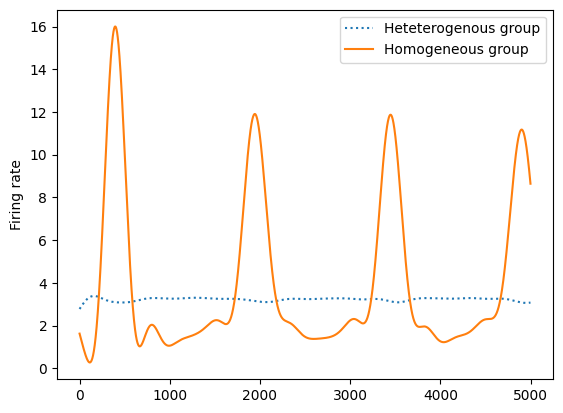

In [17]:
not_less_connected = np.setdiff1d(np.arange(N),less_connected)
plt.plot(filtered_rates_less_connected[:5000], label="Heteterogenous group", linestyle=":")
plt.plot(filtered_rates_not_less_connected[:5000], label="Homogeneous group", linestyle="-")
plt.ylabel("Firing rate")
#plt.ylim([0,12])
plt.legend()
plt.show()

In [18]:

autocorr_less_connected = get_autcorr(filtered_rates_less_connected)
autocorr_not_less_connected = get_autcorr(filtered_rates_not_less_connected)


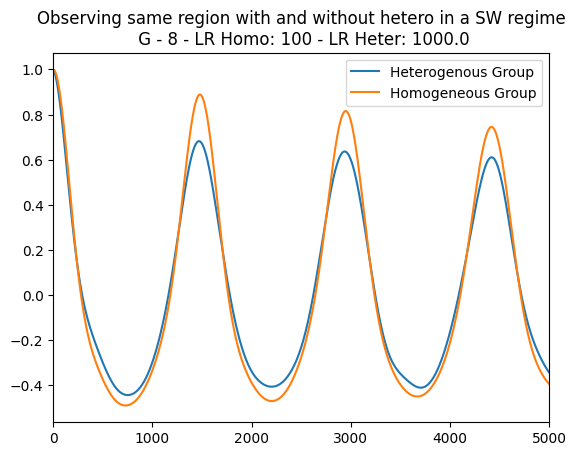

In [19]:
lags = np.arange(0,len(autocorr_less_connected))
plt.plot(lags, autocorr_less_connected,label='Heterogenous Group')
plt.plot(lags,autocorr_not_less_connected,label='Homogeneous Group')

plt.xlim([0,5000])
plt.title(f"Observing same region with and without hetero in a SW regime\n G - {params['G']} - LR Homo: {params['lrj']} - LR Heter: {params_heter['lr_receptors'][less_connected[0]]}")
plt.legend()

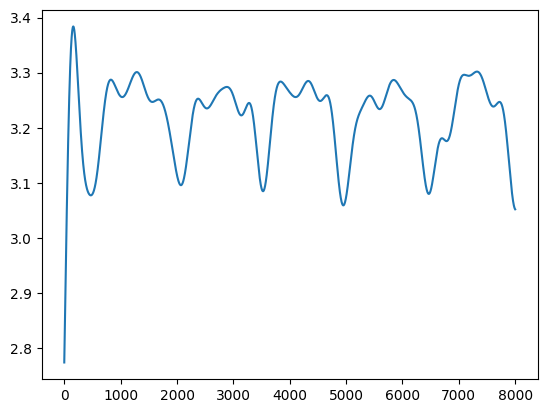

In [27]:
plt.plot(filtered_rates_less_connected[:8000].T)

In [28]:

unfiltered_autocorr_less_connected = get_autcorr(np.mean(rates_heter[less_connected],axis=0))
unfiltered_autocorr_not_less_connected = get_autcorr(np.mean(rates_heter[not_less_connected],axis=0))


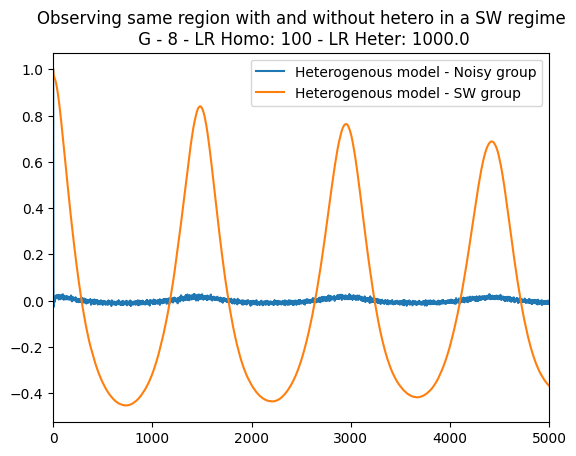

In [35]:
lags = np.arange(0,len(unfiltered_autocorr_less_connected))
plt.plot(lags, unfiltered_autocorr_less_connected,label='Heterogenous model - Noisy group')
plt.plot(lags,unfiltered_autocorr_not_less_connected,label='Heterogenous model - SW group')

plt.xlim([0,5000])
plt.title(f"Observing same region with and without hetero in a SW regime\n G - {params['G']} - LR Homo: {params['lrj']} - LR Heter: {params_heter['lr_receptors'][less_connected[0]]}")
plt.legend()